# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Laura Ruis"
NAME2 = "Fredie Haver"
NAME3 = "Lukás Jelínek"
EMAIL = "lauraruis@live.nl"
EMAIL2 = "frediehaver@hotmail.com"
EMAIL3 = "lukas.jelinek1@gmail.com"

---

# Lab 2: Classification

### Machine Learning 1, September 2017

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

Populating the interactive namespace from numpy and matplotlib


# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [3]:
from sklearn.datasets import fetch_mldata
# Fetch the data
mnist = fetch_mldata('MNIST original')
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

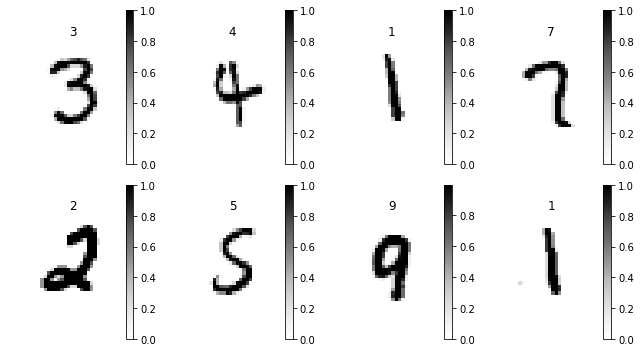

In [4]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} \\
&= 1 - \frac{1}{Z} \frac{\partial \sum_i \exp (\log (q_i))}{\partial \log(q_j)} \\
&= 1 - \frac{1}{Z} \exp (\log (q_j)) \\
&= 1 - \frac{q_j}{Z} 
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} \\
&= - \frac{q_j}{Z}
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

$
\frac{\partial \log q_j}{\partial W_{ij}} = \frac{\partial }{\partial W_{ij}}(\textbf{w}^T_{j} \textbf{x} + b_{j}) = \frac{\partial }{\partial W_{ij}} (\sum_i W_{ij}x_i +b_j) = x_i
$

So 

$\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =  \mathbf{\delta}_j^q x_i $

### 1.1.2 Implement gradient computations (10 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [5]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    
    # define dimensions
    dim_k = w.shape[1]
    dim_m = w.shape[0]
    
    # compute q vector and Z
    logq = (w.T @ x.T).squeeze() + b
    q = exp(logq)
    Z = np.sum(q)
    
    # compute delta vector
    delta = -(1/Z) * q
    delta[t] = 1 + delta[t]
            
    dL_dw = (np.reshape(delta, (dim_k,1)) @ x).transpose()

    # compute logp
    a = np.amax(np.log(q))
    logZ = a + np.log(np.sum(np.exp(-a) * q))
    logp = np.reshape(np.log(q) - logZ, (1,dim_k))
    dL_db = delta
    
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()

In [6]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [7]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide can compute the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 4.87274339662e-07
Finite difference error grad_b: 4.03972930866e-08



### 1.1.3 Stochastic gradient descent (10 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1E-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [8]:
def sgd_iter(x_train, t_train, W, b):

    # get vector with random indices and intialize vector for logpt
    l = len(t_train)
    w_old = W
    b_old = b
    rand_list = [i for i in range(l)]
    shuffle(rand_list)
    logp_train = [0 for i in range(l)]
    
    # get gradient
    logpt, grad_w, grad_b = logreg_gradient(x_train[rand_list[0]:rand_list[0]+1,:], t_train[rand_list[0]:rand_list[0]+1], W, b)
    logp_train[0] = np.asscalar(logpt)
    learning_rate = 1 * 10**(-6)
    w_new = w_old + learning_rate * grad_w
    b_new = b_old + learning_rate * grad_b
    
    # go through dataset in randomized order
    for i in range(1, l):
        logpt, grad_w, grad_b = logreg_gradient(x_train[rand_list[i]:rand_list[i] + 1,:], t_train[rand_list[i]:rand_list[i] + 1],
                                                w_new, b_new)
        w_new = w_new + learning_rate * grad_w
        b_new = b_new + learning_rate * grad_b
        logp_train[i] = np.asscalar(logpt)

    logp_train_mean = mean(logp_train)
    
    return logp_train_mean, w_new, b_new

In [9]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)


## 1.2. Train

### 1.2.1 Train (10 points)
Perform 10 SGD iterations through the trainingset. Plot (in one graph) the conditional log-probability of the trainingset and validation set after each iteration.


iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9


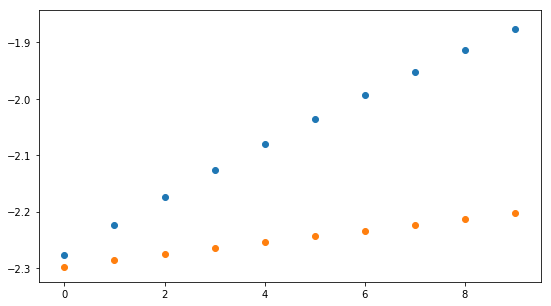

In [10]:
iterations = 10 
def test_sgd(x_train, t_train, w, b):
    iterations = 10 
    w_old = w
    logp_iter = [0 for i in range(iterations)]
    logp_iter_valid = [0 for i in range(iterations)]
    w_valid = w_old
    b_valid = b
    for i in range(iterations):
        print('iteration: ', i)
        
        # training set
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        logp_iter[i] = logp_train
        
        # validation est
        logp_valid_train, w_valid, b_valid = sgd_iter(x_valid, t_valid, w_valid, b_valid)
        logp_iter_valid[i] = logp_valid_train
        
    return logp_iter, logp_iter_valid, w, b, b_valid

np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)

logp_iter, logp_iter_valid, w, b, b_valid = test_sgd(x_train, t_train, w, b)
plt.scatter(range(iterations), logp_iter)
plt.scatter(range(iterations), logp_iter_valid)
plt.show()

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


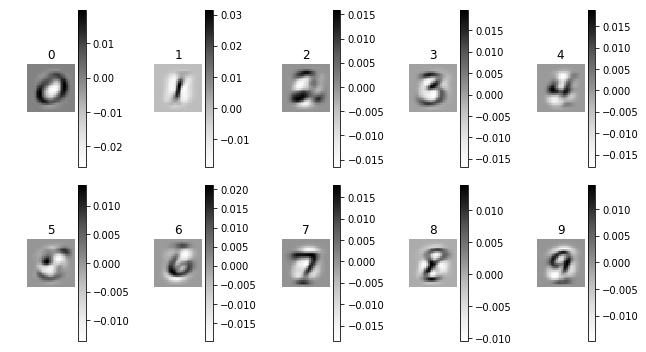

In [11]:
tars = [i for i in range(10)]
plot_digits(w.transpose(), num_cols=5, targets=tars)

**Describe in less than 100 words why these weights minimize the loss**

These weights are found with SGD (ascent) for maximizing the log-likelihood. In multiclass logistic regression the loss is the negative log-likelihood. These weights maximize the log-likelihood, so they minimize the negative log-likelihood e.g. the loss.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.
Ask yourself if these results make sense.

Highest probability of true class label: 


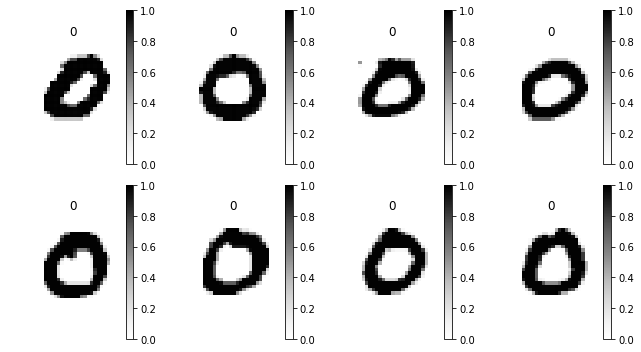

Lowest probability of true class label: 


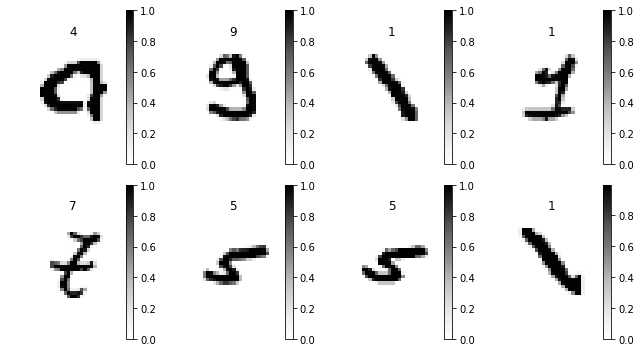

In [12]:
logps = [0 for i in range(len(t_valid))]

for i in range(len(t_valid)):
    logpt, grad_w, grad_b = logreg_gradient(x_valid[i:i+1,:], t_valid[i:i+1], w, b_valid)
    logps[i] = np.asscalar(logpt)

sorted_logps = np.sort(logps)
highest = sorted_logps[-8:]
highest_t = [t_valid[logps.index(i)] for i in highest]
highest_x = np.concatenate([x_valid[logps.index(i):logps.index(i)+1,:] for i in highest])
lowest = sorted_logps[:8]
lowest_t = [t_valid[logps.index(i)] for i in lowest]
lowest_x = np.concatenate([x_valid[logps.index(i):logps.index(i)+1,:] for i in lowest])

print("Highest probability of true class label: ")
plot_digits(highest_x, num_cols=4, targets=highest_t)

print("Lowest probability of true class label: ")
plot_digits(lowest_x, num_cols=4, targets=lowest_t)

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron wil have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$.

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

K = size of output layer. In this example K = 10 

I = size of input layer. In this example I = 784

First we calculate the delta:

\begin{align}
 \frac{\partial \log q_j}{\partial h_j} &=
 \left(\frac{\partial}{\partial h_j}\left(\sum_{i=1}^{L}w_{i,j}h_i\right) 
       + \frac{\partial}{\partial h_j}\left(b_j\right)\right) \\
&= W_{j,j}
\end{align}

\begin{align}
 \frac{\partial Z}{\partial \log q_j} = \frac{\partial}{\partial \log q_j}\left(\sum_{k=1}^{K}q_k\right) = q_j  
\end{align}

For $j = t^{(n)}$:
\begin{align}
\delta_{j}^{h}
&= \frac{\partial \log q_j}{\partial \log q_j}  \frac{\partial \log q_j}{\partial h_j}
- \frac{\partial \log Z}{\partial Z} \frac{\partial Z}{\partial \log q_j} \frac{\partial \log q_j}{\partial h_j} \\
&=W_{j,j} - \frac{W_{j,j}}{Z}q_j
\end{align}

For $j \neq t^{(n)}$:
\begin{align}
\delta_{j}^{h}
&= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
\frac{\partial \log q_j}{\partial \log h_j}\\
&= - \frac{W_{j,j}}{Z}q_j
\end{align}


The elements of the gradient with respect to the bias $\nabla_{\bb} \mathcal{L}^{(n)}$:

For $j \neq t^{(n)}$:
\begin{align}
\frac{\partial \log q_j}{\partial b_j}&= 1\\
\frac{\partial \mathcal{L}^{n}}{\partial b_j} &= 
\frac{\partial \log q_j}{\partial \log q_j} 
\frac{\partial \log q_j}{\partial b_j}
- \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
\frac{\partial \log q_j}{\partial b_j} \\
&= 1- \frac{q_j}{Z}
\end{align}

For $j \neq t^{(n)}$:
\begin{align}
\frac{\partial \mathcal{L}^{n}}{\partial b_j} = - \frac{q_j}{Z} 
\end{align}

The Bias is the same as in the case of Logistic regression because the activations of the hidden layer do not change the bias from the ones in the multiclass logistic regression (the dependence on the bias does not change).

The elements of the gradient with respect to the weights $W_{k,j}$ $\nabla_{\bW} \mathcal{L}^{(n)}$:

For $j \neq t^{(n)}$:
\begin{align}
\frac{\partial \log q_j}{\partial W_{i,j}} &= 
\left(\frac{\partial}{\partial  W_{i,j}}\left(\sum_{i=1}^{L}w_{i,j}h_i\right) 
       + \frac{\partial}{\partial  W_{i,j}}\left(b_j\right)\right) \\
&= h_{i}\\
\frac{\partial \mathcal{L}^{n}}{\partial W_{i,j}} &= 
\frac{\partial \log q_j}{\partial \log q_j} 
\frac{\partial \log q_j}{\partial W_{i,j}}
- \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
\frac{\partial \log q_j}{\partial W_{i,j}} \\
&= h_i - \frac{q_j}{Z}h_i
\end{align}

For $j \neq t^{(n)}$:
\begin{align}
\frac{\partial \mathcal{L}^{n}}{\partial W_{i,j}} = - \frac{q_j}{Z}h_i 
\end{align}

The weight vector is similar to logistic regresion because they only depend on the hidden layer h linearly and that comes back in the multiplication with h in the gradient.

The elements of the gradient with respect to the biases $ a_j$ $\nabla_{\ba} \mathcal{L}^{(n)}$:

\begin{align}
\frac{\partial}{\partial a_j}\left(v_j x+ a_j\right) &=1 \\
\frac{\partial \mathcal{L}^{n}}{\partial a_{j}} &= \delta_{j}^{h} 
\frac{\partial h_j}{\partial \sigma(s)} 
\frac{\partial \sigma(s)}{\partial s} 
\frac{\partial s}{\partial a_j} \\
&= \delta_{j}^{h} \sigma \left(v_j x+ a_j\right) (1- \sigma \left(v_j x+ a_j\right))
\end{align}

The elements of the gradient with respect to the weights $V_{i,j}$ $\nabla_{\bV} \mathcal{L}^{(n)}$:

\begin{align}
\frac{\partial}{\partial V_{i,j}}\left(v_j x+ a_j\right) &= 
\left(\frac{\partial}{\partial V_{i,j}}\left(\sum_{i=1}^{I}V_{i,j}x_i\right) 
       + \frac{\partial}{\partial V_{i,j}}\left(a_j\right)\right) = x_i\\
\frac{\partial \mathcal{L}^{n}}{\partial V_{i,j}} &= \delta_{j}^{h} 
\frac{\partial h_j}{\partial \sigma(s)} 
\frac{\partial \sigma(s)}{\partial s} 
\frac{\partial s}{\partial V_{i,j}} \\
&= \delta_{j}^{h} \sigma \left(v_j x+ a_j\right) (1- \sigma \left(v_j x+ a_j\right))x_i
\end{align}


## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

We could extend this by changing the $\mathcal{L}^{(n)}$, or the function we are trying to optimize. In this case we are optimizing the likelihood, but if we want to include some prior belief on the distribution of the parameters we should add a Gaussian prior. Now the gradient descent algorithm tries to adjust the weights to minimize the posterior distribution instead of the likelihood. This would mean different gradient equations, updates and a different final output.

## 2.3. Implement and train a MLP (15 points)

Implement a MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Plot (in one graph) the conditional log-probability of the trainingset and validation set after each two iterations, as well as the weights.

- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [13]:
import math

def sigmoid(z):
    return 1.0/(1.0+np.exp(np.negative(z)))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))


class Network(object):
    def  __init__(self,sizes):
        self.num_layers = len(sizes)-1
        self.sizes = sizes
        self.biases = [np.random.randn(1,j) for j in self.sizes[1:]]
        self.b_grads = [np.zeros((1,j)) for j in self.sizes[1:]]
        
        self.weights = [(np.random.randn(y, x)/np.sqrt(x)).transpose()                
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.w_grads = [np.zeros((y, x)).transpose()
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        
        self.activations = [np.zeros((1,j)) for j in self.sizes]
#         print('V',self.weights[0].shape,'a',self.biases[0].shape,'activ:',self.activations[0].shape)
#         print('W',self.weights[1].shape,'b',self.biases[1].shape,'activ2:',self.activations[1].shape)
    
    def feedForward(self,x):
        self.activations[0] =  x.reshape((1,len(x)))
        for i,b,w in zip(range(1,self.num_layers),self.biases[:-1],self.weights[:-1]):
            self.activations[i]= sigmoid(self.activations[i-1].dot(w) + b)
        # last layer activation no activation function
        self.activations[-1] = self.activations[-2].dot(self.weights[-1]) + self.biases[-1]
        return self.activations[-1]
    
    def SGD(self,x,t,learn):
        idx = list(range(len(x_train)))
        random.shuffle(idx)
        log_train = 0
        for i in idx:
            self.feedForward(x[i,:])
            err = self.backprop(t[i])
            for i in range(self.num_layers):
                self.biases[i] += learn * self.b_grads[i]
                self.weights[i] += learn * self.w_grads[i]
            log_train +=err
        return log_train
        
    
    def backprop(self,t):
        max_activ = np.max(self.activations[-1])
        logZ = max_activ + np.log(np.sum(np.exp(self.activations[-1] - max_activ)))
        logp = self.activations[-1] - logZ
        
        # solving weights changes for last layer
        d = np.zeros(self.activations[-1].shape[1])
        d[t] = 1
        delta_q = d - np.exp(self.activations[-1])/np.exp(logZ)
        self.w_grads[-1] = self.activations[-2].T * delta_q
        self.b_grads[-1] = delta_q
        
        delta_h = delta_q.dot(self.weights[-1].T)
        for i in range(1,self.num_layers):
            curr_l = self.num_layers - i
            prev_l = curr_l +1
            next_l = curr_l -1
            sigmoid_prime = self.activations[curr_l]*(1-self.activations[curr_l])
            self.w_grads[curr_l-1] = self.activations[next_l].T.dot(delta_h*sigmoid_prime)
           
            self.b_grads[curr_l-1] = delta_h*sigmoid_prime
            delta_h = delta_h.dot(self.weights[curr_l-1].T)
#         print(logp[0,t])
        return logp[0,t].squeeze()
    
    def validate(self,x,t):
        self.feedForward(x)
        max_activ = np.max(self.activations[-1])
        logZ = max_activ + np.log(np.sum(np.exp(self.activations[-1] - max_activ)))
        logp = self.activations[-1] - logZ
#         print(logp)
        return logp[0,t]


def test_mlp(x_train, t_train, x_valid, t_valid, network,learn=1e-2):
    
    measure_points=[]
    t_logp = []
    v_logp = []
    
    iterations = 10
    
    for i in range(iterations):
        print(i)
        logp_train = network.SGD(x_train,t_train,learn)

        if i %2 ==0:
            measure_points.append(i)
            t_logp.append(logp_train)
            sum_valid = 0
            for j in range(len(t_valid)):
                sum_valid += network.validate(x_valid[j,:],t_valid[j])
            v_logp.append(sum_valid)
            print('Iteration ' + str(i))
            plot_digits(network.weights[0].transpose(), num_cols=5,shape=(28,28))

    fig, ax = plt.subplots()

    ax.plot(measure_points, t_logp, marker='.')
    ax.plot(measure_points, v_logp, marker='.')
    plt.legend(['train', 'validation'])
    plt.show()
    return v_logp[-1]


        

0
Iteration 0


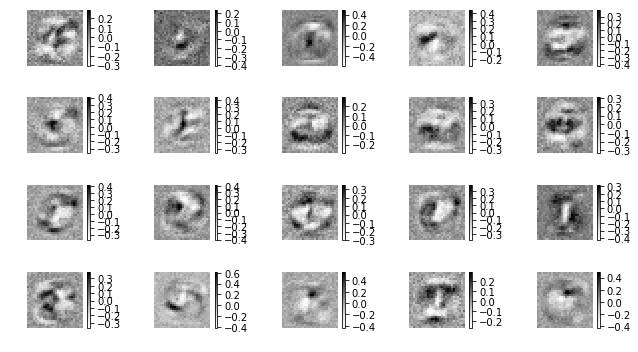

1
2
Iteration 2


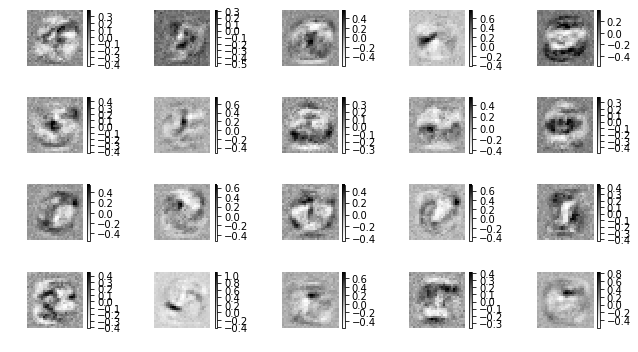

3
4
Iteration 4


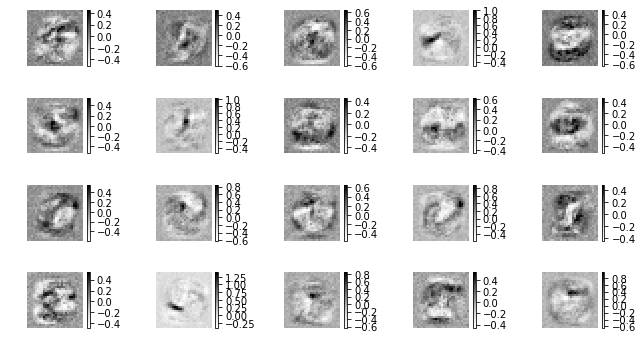

5
6
Iteration 6


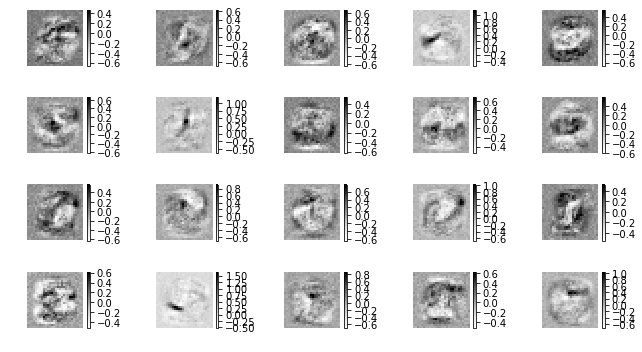

7
8
Iteration 8


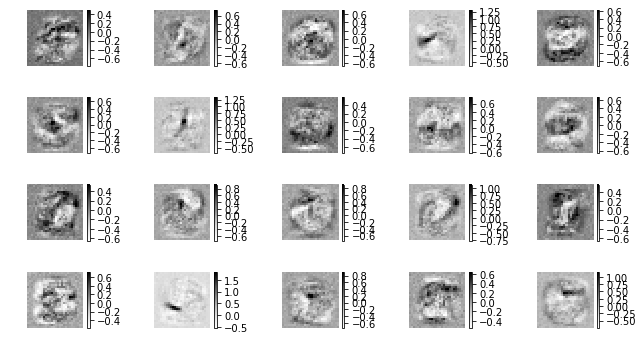

9


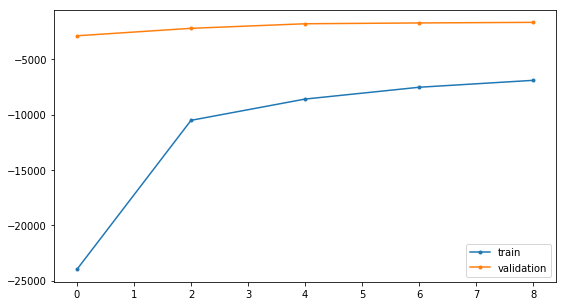

-1674.4735154458742

In [14]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

np.random.seed(99)
nt = Network([784,20,10])
test_mlp(x_train, t_train, x_valid, t_valid,nt)

### 2.3.1. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

The weight are more noisy but they represent different structure than in case of lienar regression.

### 2.3.1. Less than 250 misclassifications on the test set (10 bonus points)

You receive an additional 10 bonus points if you manage to train a model with very high accuracy: at most 2.5% misclasified digits on the test set. Note that the test set contains 10000 digits, so you model should misclassify at most 250 digits. This should be achievable with a MLP model with one hidden layer. See results of various models at : `http://yann.lecun.com/exdb/mnist/index.html`. To reach such a low accuracy, you probably need to have a very high $L$ (many hidden units), probably $L > 200$, and apply a strong Gaussian prior on the weights. In this case you are allowed to use the validation set for training.
You are allowed to add additional layers, and use convolutional networks, although that is probably not required to reach 2.5% misclassifications.

In [15]:
predict_test = np.zeros(len(t_test))
# Fill predict_test with the predicted targets from your model, don't cheat :-).
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [ ]:
assert predict_test.shape == t_test.shape
n_errors = np.sum(predict_test != t_test)
print('Test errors: %d' % n_errors)